#Import

In [91]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
import re 
import string
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

#Dataset Preparation

In [80]:
df = pd.read_csv('/content/twitter_training.csv', sep=',', names=['Tweet_ID','Entity','Sentiment','Tweet_content'])

In [66]:
df.head()

,Tweet_ID,Entity,Sentiment,Tweet_content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: Sentiment, dtype: int64


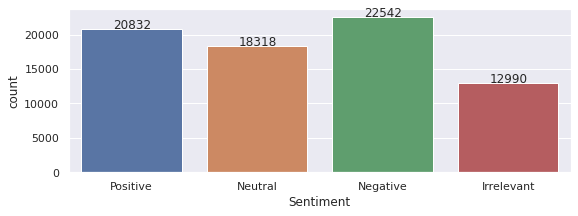

In [67]:
print(df['Sentiment'].value_counts())
ax = sns.countplot(x=df["Sentiment"])
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.02))

sns.set(rc={'figure.figsize':(9,3)})
plt.show()

##Dataset Cleaning

In [69]:
df.isnull().sum()

Tweet_ID           0
Entity             0
Sentiment          0
Tweet_content    686
dtype: int64

In [70]:
df = df.dropna()
df = df.reset_index(drop=True)
df.isnull().sum()

Tweet_ID         0
Entity           0
Sentiment        0
Tweet_content    0
dtype: int64

In [71]:
df.shape

(73996, 4)

In [72]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}
def clean_text(text):
    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'(\w)(\1{2,})', r"\1", text) #will replace repated char
    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

In [73]:
x = df['Tweet_content'].apply(lambda p: clean_text(p))

In [74]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [75]:
import re 
REPLACE_WITH_SPACE = re.compile("(@)")
SPACE = " "
from nltk.corpus import stopwords
english_stop_words = stopwords.words('english')
from nltk.stem.porter import PorterStemmer

def reviews(reviews):  
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line.lower()) for line in reviews]
    
    return reviews

def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split()  if word not in english_stop_words]))
    return removed_stop_words

def get_stemmed_text(corpus):
    stemmer = PorterStemmer()

    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]

In [76]:
y =df['Sentiment']

In [77]:
reviewtweet = reviews(x)
text_preprocessed = remove_stop_words(reviewtweet)
text_preprocessed = get_stemmed_text(text_preprocessed)

In [84]:
#Before Preprocessing
df.loc[10, 'Tweet_content']

"2010 So I spent a few hours making something for fun. . . If you don't know I am a HUGE RhandlerR fan and Maya is one of my favorite characters. So I decided to make myself a wallpaper for my PC. . Here is the original image versus the creation I made :) Enjoy! pic.twitter.com/mLsI5wf9Jg"

In [61]:
#After Preprocessing
text_preprocessed[10]

'spent hour make someth fun dont know huge rhandlerr fan maya one favorit charact decid make wallpap pc origin imag versu creation made enjoy pictwittercommlsiwfjg'

##Encoding

In [86]:
max_words = 8000


tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)
tokenizer.fit_on_texts(text_preprocessed)
x = tokenizer.texts_to_sequences(text_preprocessed)
x = pad_sequences(x, maxlen = 300)

In [87]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)

y = np.array(label_tokenizer.texts_to_sequences(y))

##Split Data
Data Train 80% Data Validation 20%

In [88]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8)

#Model

In [90]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = max_words, output_dim = 128, input_length = 300))
model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(128, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dense(128, activation = 'relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(5, activation = 'softmax'))
model_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

In [94]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 128)          1024000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 300, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                        

In [93]:
history = model_lstm.fit(
    x_train,
    y_train,
    validation_data=(x_test,y_test) , 
    epochs = 30,
    batch_size = 512,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
)

Epoch 1/30
116/116 [==============================] - 495s 4s/step - loss: 1.2145 - accuracy: 0.4513 - val_loss: 0.9527 - val_accuracy: 0.6209
Epoch 2/30
116/116 [==============================] - 494s 4s/step - loss: 0.8429 - accuracy: 0.6733 - val_loss: 0.7852 - val_accuracy: 0.6938
Epoch 3/30
116/116 [==============================] - 485s 4s/step - loss: 0.6979 - accuracy: 0.7346 - val_loss: 0.7097 - val_accuracy: 0.7277
Epoch 4/30
116/116 [==============================] - 480s 4s/step - loss: 0.6229 - accuracy: 0.7639 - val_loss: 0.6775 - val_accuracy: 0.7468
Epoch 5/30
116/116 [==============================] - 475s 4s/step - loss: 0.5705 - accuracy: 0.7830 - val_loss: 0.6437 - val_accuracy: 0.7610
Epoch 6/30
116/116 [==============================] - 475s 4s/step - loss: 0.5268 - accuracy: 0.8009 - val_loss: 0.6157 - val_accuracy: 0.7749
Epoch 7/30
116/116 [==============================] - 470s 4s/step - loss: 0.4855 - accuracy: 0.8175 - val_loss: 0.5967 - val_accuracy: 0.7802

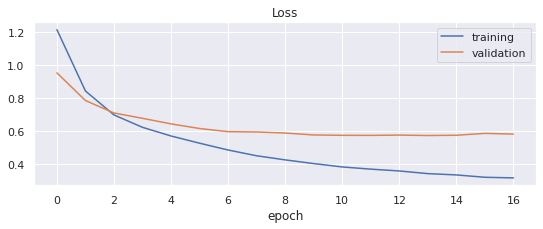

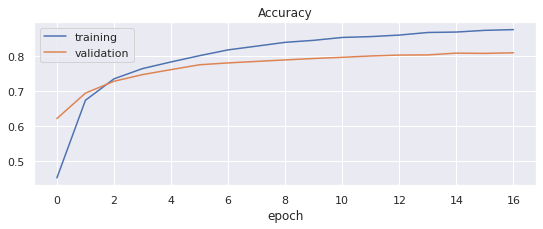

In [95]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.show()